In [72]:
#ensembling
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert
from sklearn.neighbors import KNeighborsClassifier
from sklearn_crfsuite import scorers, CRF
from sklearn.pipeline import Pipeline
import json
from operator import itemgetter


### Define static parameters for data

In [116]:
dir_name='reparse'
docs_map_name = 'scaled.binary.5_stop_docs_map.json'
crf_params_name='0.81_20.07_06:31_best_params.json'
per_par=True
seq_len=3
step=3
test_doc_num = 10
n_splits = 3
seed=42
cv_db = pd.DataFrame()

### Define test documents

In [117]:
imp.reload(model_utils)
x=np.arange(1,81)
cv_splits=model_utils.get_test_train_splits(x,test_doc_num,n_splits,seed)
cv_splits

{0: {'test': array([ 1, 12, 13, 20, 21, 41, 46, 55, 59, 76]),
  'train': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18, 19, 22,
         23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
         40, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 60,
         61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78,
         79, 80])},
 1: {'test': array([ 6,  8, 14, 19, 35, 36, 45, 60, 65, 69]),
  'train': array([ 1,  2,  3,  4,  5,  7,  9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21,
         22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40,
         41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
         59, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78,
         79, 80])},
 2: {'test': array([24, 25, 28, 34, 37, 40, 44, 49, 54, 77]),
  'train': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 26, 27, 29, 30, 31, 3

### Load docs_map

In [44]:
imp.reload(common_utils)
docs_map=common_utils.get_docs_map(dir_name,docs_map_name,per_par,seq_len,step)

In [46]:
docs_map[1].keys()

dict_keys(['X_3_3', 'y_3_3', 'groups_3_3', 'X_bert', 'y_bert'])

### Cross-validate CRF

#### Load best CRF params

In [48]:
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,crf_params_name)
with open(json_path,'r') as fp:
    best_params_crf = json.load(fp)

In [64]:
imp.reload(model_utils)
cv_db_crf=model_utils.prepared_cross_validate_crf(cv_db,docs_map, cv_splits, seq_len=3, step=3,**best_params_crf)

0 split started...
0 split fit took 18.38 sec
0 split predict took 0.38 sec
1 split started...
1 split fit took 18.69 sec
1 split predict took 0.39 sec
2 split started...
2 split fit took 18.82 sec
2 split predict took 0.35 sec


In [65]:
cv_db_crf

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1
0,1,0,not_nar,not_nar,0.937719,0.062281
1,1,0,not_nar,not_nar,0.977131,0.022869
2,1,0,not_nar,not_nar,0.995149,0.004851
3,1,0,not_nar,not_nar,0.769711,0.230289
4,1,0,not_nar,not_nar,0.807505,0.192495
...,...,...,...,...,...,...
14585,77,2,not_nar,not_nar,0.980979,0.019021
14586,77,2,not_nar,not_nar,0.984926,0.015074
14587,77,2,not_nar,not_nar,0.982102,0.017898
14588,77,2,not_nar,not_nar,0.997945,0.002055


In [106]:
cv_db_crf['crf_group'].unique()

array([ 1, 12, 13, 20, 21, 41, 46, 55, 59, 76,  6,  8, 14, 19, 35, 36, 45,
       60, 65, 69, 24, 25, 28, 34, 37, 40, 44, 49, 54, 77])

Split 0
              precision    recall  f1-score   support

      is_nar       0.74      0.55      0.63      1697
     not_nar       0.80      0.90      0.85      3354

    accuracy                           0.78      5051
   macro avg       0.77      0.73      0.74      5051
weighted avg       0.78      0.78      0.77      5051

Split 1
              precision    recall  f1-score   support

      is_nar       0.61      0.50      0.55      1158
     not_nar       0.86      0.91      0.89      4088

    accuracy                           0.82      5246
   macro avg       0.74      0.70      0.72      5246
weighted avg       0.81      0.82      0.81      5246

Split 2
              precision    recall  f1-score   support

      is_nar       0.56      0.36      0.44       972
     not_nar       0.83      0.92      0.87      3321

    accuracy                           0.79      4293
   macro avg       0.70      0.64      0.66      4293
weighted avg       0.77      0.79      0.77      4

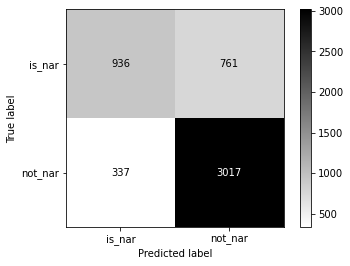

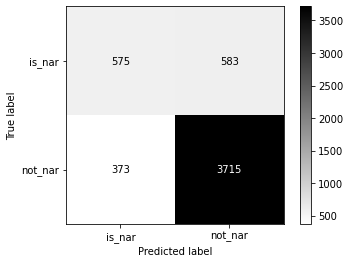

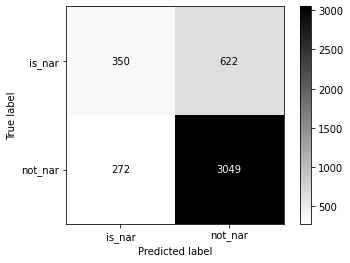

In [67]:
imp.reload(model_utils)
model_utils.get_report_from_splits(cv_db_crf,"crf")

In [118]:
imp.reload(my_bert)
bert_cv=pd.DataFrame()
cv_db_bert=my_bert.prepared_cross_validate_bert(bert_cv,docs_map, cv_splits)

Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


BertXYTransformer>>>>>>>init() called
0 split started...
BertXYTransformer>>>>>>>transform() called for 70 docs
y labels are
 BertXYTransformer>>>>>>>transform() done for 33730 samples, labels are [0. 1.]
BertXYTransformer>>>>>>>transform() called for 10 docs
y labels are
 BertXYTransformer>>>>>>>transform() done for 5051 samples, labels are [0. 1.]
BertTrainValidator>>>>>>> init() called
BertTrainValidator>>>>>>> train_validate() called
Class Weights: [0.66371507 2.02704327]

 Epoch 1 / 10

Evaluating...
train_validate() raw_preds tensor([[-0.9291, -0.5024],
        [-0.3347, -1.2573],
        [-0.4534, -1.0092],
        ...,
        [-0.4234, -1.0636],
        [-0.6264, -0.7647],
        [-0.3347, -1.2573]])
Saving best model bert

Training Loss: 0.670

Validation Loss: 0.660

 Epoch 2 / 10

Evaluating...
train_validate() raw_preds tensor([[-0.8668, -0.5452],
        [-0.2394, -1.5469],
        [-0.2833, -1.3996],
        ...,
        [-0.2906, -1.3777],
        [-0.3340, -1.2591],
 

train_validate() raw_preds tensor([[-0.0661, -2.7488],
        [-0.0661, -2.7488],
        [-0.0263, -3.6512],
        ...,
        [-0.0275, -3.6072],
        [-0.0395, -3.2506],
        [-0.0296, -3.5357]])

Training Loss: 0.263

Validation Loss: 0.179

 Epoch 5 / 10

Evaluating...
train_validate() raw_preds tensor([[-0.0739, -2.6416],
        [-0.0739, -2.6416],
        [-0.0233, -3.7713],
        ...,
        [-0.0243, -3.7283],
        [-0.0279, -3.5928],
        [-0.0258, -3.6699]])

Training Loss: 0.248

Validation Loss: 0.181

 Epoch 6 / 10

Evaluating...
train_validate() raw_preds tensor([[-0.0699, -2.6949],
        [-0.0699, -2.6949],
        [-0.0201, -3.9147],
        ...,
        [-0.0212, -3.8663],
        [-0.0238, -3.7514],
        [-0.0222, -3.8203]])

Training Loss: 0.240

Validation Loss: 0.187

 Epoch 7 / 10

Evaluating...
train_validate() raw_preds tensor([[-0.0637, -2.7849],
        [-0.0637, -2.7849],
        [-0.0173, -4.0653],
        ...,
        [-0.0180, -4.

In [119]:
cv_db_bert

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1
0,1,0,0,0,0.526763,0.473237
1,1,0,0,0,0.782847,0.217153
2,1,0,0,0,0.791494,0.208506
3,1,0,0,0,0.674561,0.325439
4,1,0,0,0,0.527963,0.472037
...,...,...,...,...,...,...
14585,77,2,0,0,0.713230,0.286770
14586,77,2,0,0,0.945393,0.054607
14587,77,2,0,0,0.953558,0.046442
14588,77,2,0,0,0.939007,0.060993


In [123]:
imp.reload(common_utils)
common_utils.save_db(cv_db_bert,dir_name,"cv_bert")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_bert.csv,  index False


Split 0
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      3354
           1       0.67      0.45      0.54      1697

    accuracy                           0.74      5051
   macro avg       0.72      0.67      0.68      5051
weighted avg       0.73      0.74      0.73      5051

Split 1
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4088
           1       0.72      0.75      0.73      1158

    accuracy                           0.88      5246
   macro avg       0.82      0.83      0.83      5246
weighted avg       0.88      0.88      0.88      5246

Split 2
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3321
           1       0.86      0.92      0.89       972

    accuracy                           0.95      4293
   macro avg       0.92      0.94      0.93      4293
weighted avg       0.95      0.95      0.95      4

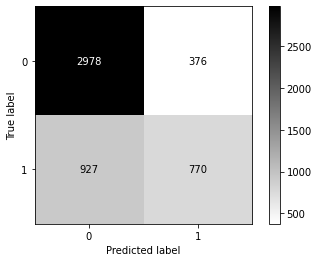

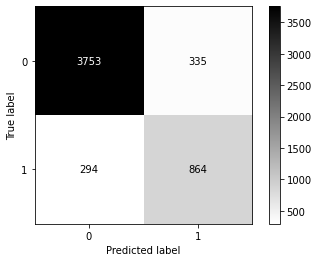

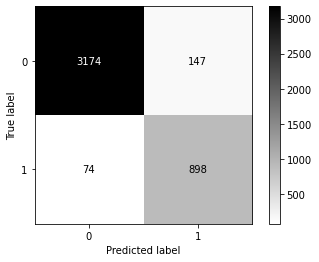

In [124]:
model_utils.get_report_from_splits(cv_db_bert,"bert")